## Bike Demand Prediction with LSTMs using TensorFlow and Keras

### My goal is to predict the number of future bike shares given the season and weather information.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('datasets_376751_731448_london_merged.csv', parse_dates=['timestamp'], index_col='timestamp')

- "timestamp" - timestamp field for grouping the data
- "cnt" - the count of a new bike shares
- "t1" - real temperature in C
- "t2" - temperature in C "feels like"
- "hum" - humidity in percentage
- "windspeed" - wind speed in km/h
- "weathercode" - category of the weather
- "isholiday" - boolean field - 1 holiday / 0 non holiday
- "isweekend" - boolean field - 1 if the day is weekend
- "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

"weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [3]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
df.shape

(17414, 9)

In [5]:
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['month'] = df.index.month

In [6]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


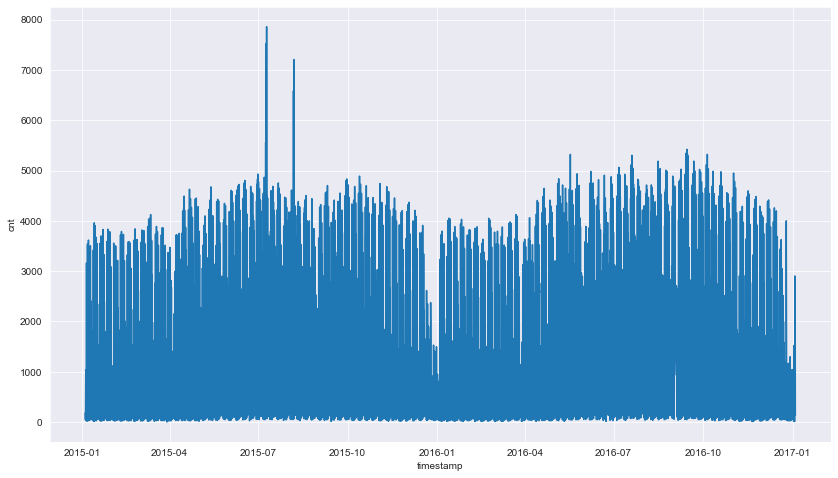

In [7]:
plt.figure(figsize=(14, 8))
sns.lineplot(x=df.index, y='cnt',data=df)

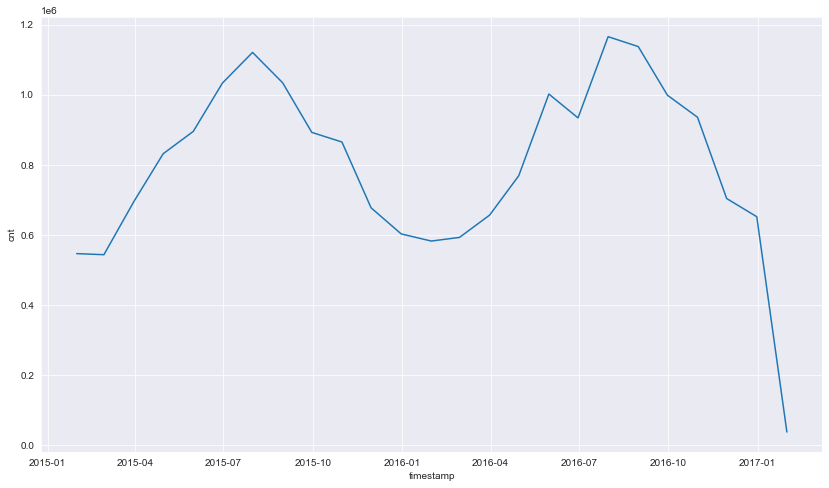

In [8]:
df_by_month = df.resample('M').sum()
plt.figure(figsize=(14, 8))
sns.lineplot(x=df_by_month.index, y='cnt',data=df_by_month)

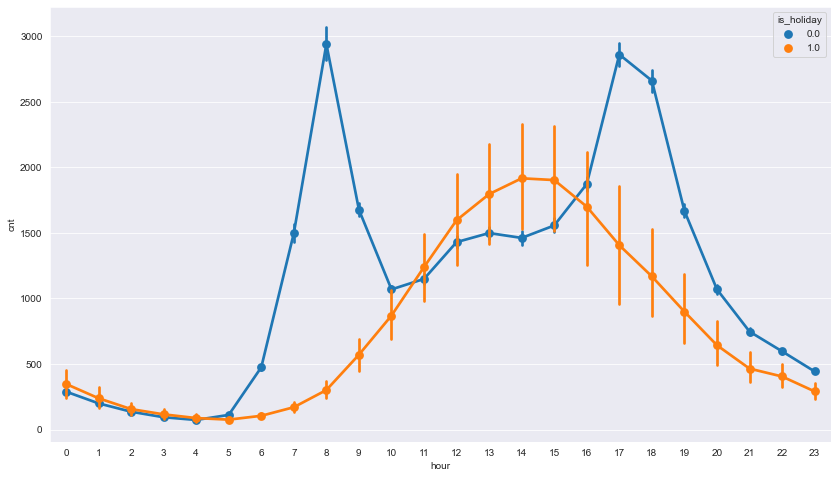

In [9]:
plt.figure(figsize=(14, 8))
sns.pointplot(x='hour', y='cnt',hue='is_holiday',data=df)

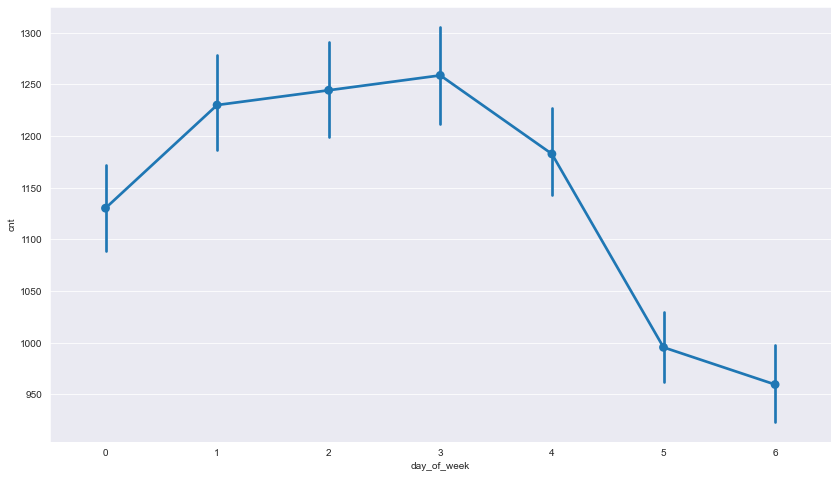

In [10]:
plt.figure(figsize=(14, 8))
sns.pointplot(x='day_of_week', y='cnt',data=df)

In [11]:
import math
# Get/Compute the number of rows to train the model on
training_data_len = math.ceil(len(df) *.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)

(17414, 13) (15673, 13) (1765, 13)


In [12]:
from sklearn.preprocessing import RobustScaler

In [13]:
# Scale all of the data from columns ['t1', 't2', 'hum', 'wind_speed']
train_trans = train[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1', 't2', 'hum', 'wind_speed']].to_numpy()
Robust_scale = RobustScaler() # Many outliners exist, so using robustscaler
train.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=Robust_scale.fit_transform(train_trans)
test.loc[:, ['t1', 't2', 'hum', 'wind_speed']]=Robust_scale.fit_transform(test_trans)

C:\Users\Elvis\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Elvis\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
#Scale the all of the data from columns ['cnt']
train['cnt'] = Robust_scale.fit_transform(train[['cnt']])
test['cnt'] = Robust_scale.fit_transform(test[['cnt']])

C:\Users\Elvis\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Elvis\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
train.to_numpy()
test.to_numpy()

array([[ 0.24331551, -0.1       ,  0.06666667, ...,  5.        ,
        22.        , 10.        ],
       [ 0.49465241,  0.2       ,  0.33333333, ...,  5.        ,
        22.        , 10.        ],
       [ 0.93761141,  0.6       ,  0.66666667, ...,  5.        ,
        22.        , 10.        ],
       ...,
       [-0.34402852, -0.6       , -0.66666667, ...,  1.        ,
         3.        ,  1.        ],
       [-0.44474153, -0.6       , -0.66666667, ...,  1.        ,
         3.        ,  1.        ],
       [-0.52049911, -0.7       , -0.73333333, ...,  1.        ,
         3.        ,  1.        ]])

In [16]:
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(len(train) - time_steps):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [17]:
#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in range(len(test) - time_steps):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    #y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

In [18]:
# [samples, time_steps, n_features]
# Using all 12 columns of data (take out the bike sharing amount column) to make prediction
print('Train data size:')
print(x_train.shape, y_train.shape)
print('Test data size:')
print(x_test.shape, y_test.shape)

Train data size:
(15649, 24, 12) (15649,)
Test data size:
(1741, 24, 12) (1741,)


In [19]:
#Build the LSTM network model
model = keras.Sequential()
model.add(keras.layers.Bidirectional(
    keras.layers.LSTM(units=50,input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
history = model.fit(x_train, y_train, epochs=200, batch_size=20, validation_split=0.15, shuffle=True)

Epoch 1/200
666/666 [==============================] - 6s 10ms/step - loss: 0.0180 - val_loss: 0.0596
Epoch 2/200
666/666 [==============================] - 7s 10ms/step - loss: 0.0157 - val_loss: 0.0572
Epoch 3/200
666/666 [==============================] - 7s 11ms/step - loss: 0.0144 - val_loss: 0.0583
Epoch 4/200
666/666 [==============================] - 6s 9ms/step - loss: 0.0144 - val_loss: 0.0631
Epoch 5/200
666/666 [==============================] - 6s 9ms/step - loss: 0.0142 - val_loss: 0.0572
Epoch 6/200
666/666 [==============================] - 7s 10ms/step - loss: 0.0149 - val_loss: 0.0612
Epoch 7/200
666/666 [==============================] - 6s 9ms/step - loss: 0.0139 - val_loss: 0.0625
Epoch 8/200
666/666 [==============================] - 6s 9ms/step - loss: 0.0137 - val_loss: 0.0601
Epoch 9/200
666/666 [==============================] - 6s 10ms/step - loss: 0.0144 - val_loss: 0.0544
Epoch 10/200
666/666 [==============================] - 6s 10ms/step - loss: 0.0140 - 

Epoch 161/200
666/666 [==============================] - 5s 8ms/step - loss: 0.0103 - val_loss: 0.0639
Epoch 162/200
666/666 [==============================] - 6s 8ms/step - loss: 0.0119 - val_loss: 0.0597
Epoch 163/200
666/666 [==============================] - 5s 8ms/step - loss: 0.0098 - val_loss: 0.0590
Epoch 164/200
666/666 [==============================] - 5s 8ms/step - loss: 0.0100 - val_loss: 0.0625
Epoch 165/200
666/666 [==============================] - 6s 9ms/step - loss: 0.0101 - val_loss: 0.0634
Epoch 166/200
666/666 [==============================] - 5s 8ms/step - loss: 0.0098 - val_loss: 0.0641
Epoch 167/200
666/666 [==============================] - 6s 9ms/step - loss: 0.0095 - val_loss: 0.0583
Epoch 168/200
666/666 [==============================] - 6s 9ms/step - loss: 0.0096 - val_loss: 0.0638
Epoch 169/200
666/666 [==============================] - 6s 9ms/step - loss: 0.0095 - val_loss: 0.0642
Epoch 170/200
666/666 [==============================] - 6s 9ms/step - lo

In [24]:
y_pred = model.predict(x_test)
y_pred = Robust_scale.inverse_transform(y_pred)#Undo scaling
y_pred

array([[ 904.99365],
       [1400.4307 ],
       [1836.1375 ],
       ...,
       [ 420.18234],
       [ 317.81763],
       [ 269.9185 ]], dtype=float32)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_lstm

395.65532677346386

In [26]:
r2 = r2_score(y_test, y_pred)
r2

0.8186864329071931

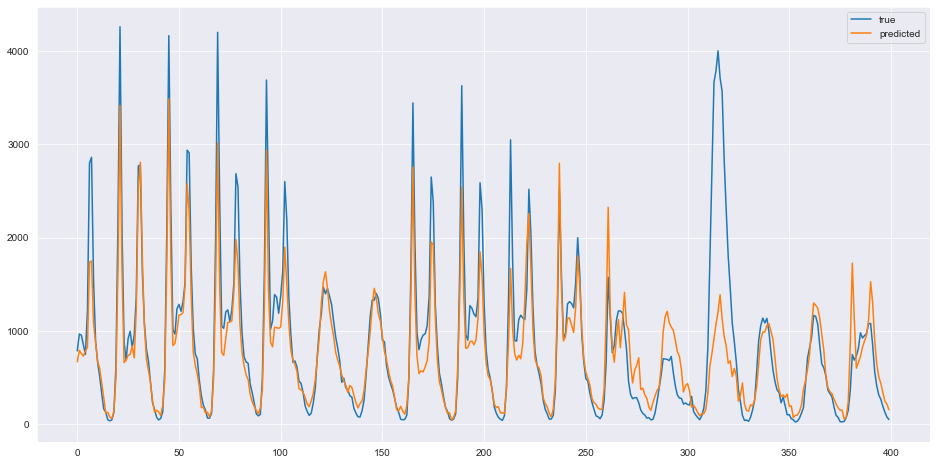

In [28]:
#Pcik some values to zoom in
plt.figure(figsize=(16, 8))
plt.plot(y_test[1200:1600], label='true')
plt.plot(y_pred[1200:1600], label='predicted')
plt.legend()